Epoch: 0/5000		Cost function: 5.473E+00
Epoch: 50/5000		Cost function: 2.366E+00
Epoch: 100/5000		Cost function: 1.985E-02
Epoch: 150/5000		Cost function: 2.875E-03
Epoch: 200/5000		Cost function: 1.311E-03
Epoch: 250/5000		Cost function: 7.615E-04
Epoch: 300/5000		Cost function: 4.963E-04
Epoch: 350/5000		Cost function: 3.490E-04
Epoch: 400/5000		Cost function: 2.657E-04
Epoch: 450/5000		Cost function: 2.163E-04
Epoch: 500/5000		Cost function: 1.837E-04
Epoch: 550/5000		Cost function: 1.592E-04
Epoch: 600/5000		Cost function: 1.388E-04
Epoch: 650/5000		Cost function: 1.212E-04
Epoch: 700/5000		Cost function: 1.058E-04
Epoch: 750/5000		Cost function: 9.225E-05
Epoch: 800/5000		Cost function: 8.048E-05
Epoch: 850/5000		Cost function: 7.031E-05
Epoch: 900/5000		Cost function: 6.157E-05
Epoch: 950/5000		Cost function: 5.407E-05
Epoch: 1000/5000		Cost function: 4.764E-05
Epoch: 1050/5000		Cost function: 4.210E-05
Epoch: 1100/5000		Cost function: 3.731E-05
Epoch: 1150/5000		Cost function: 3

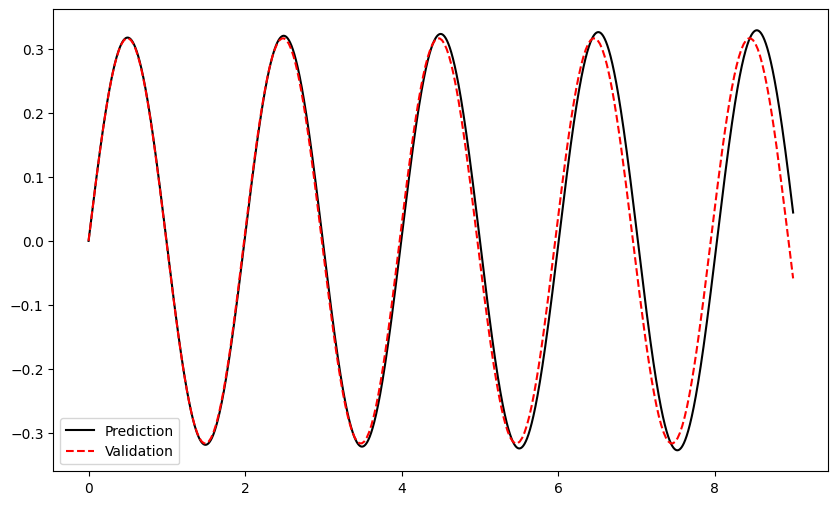

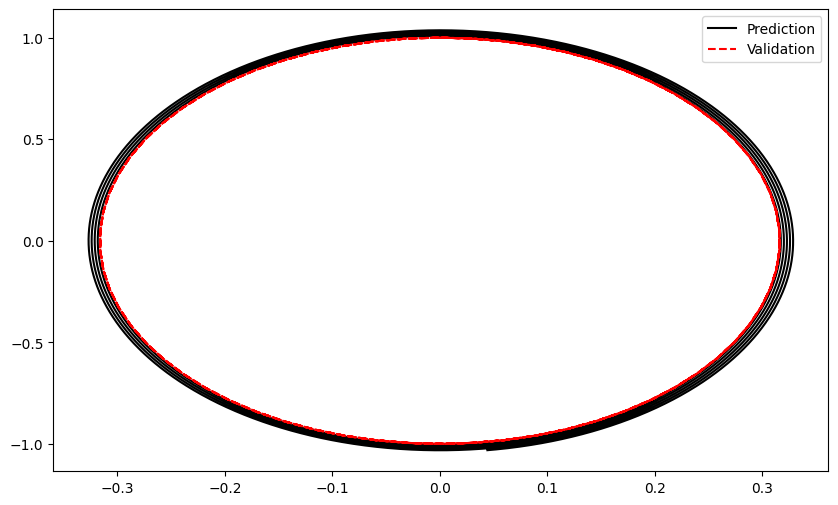

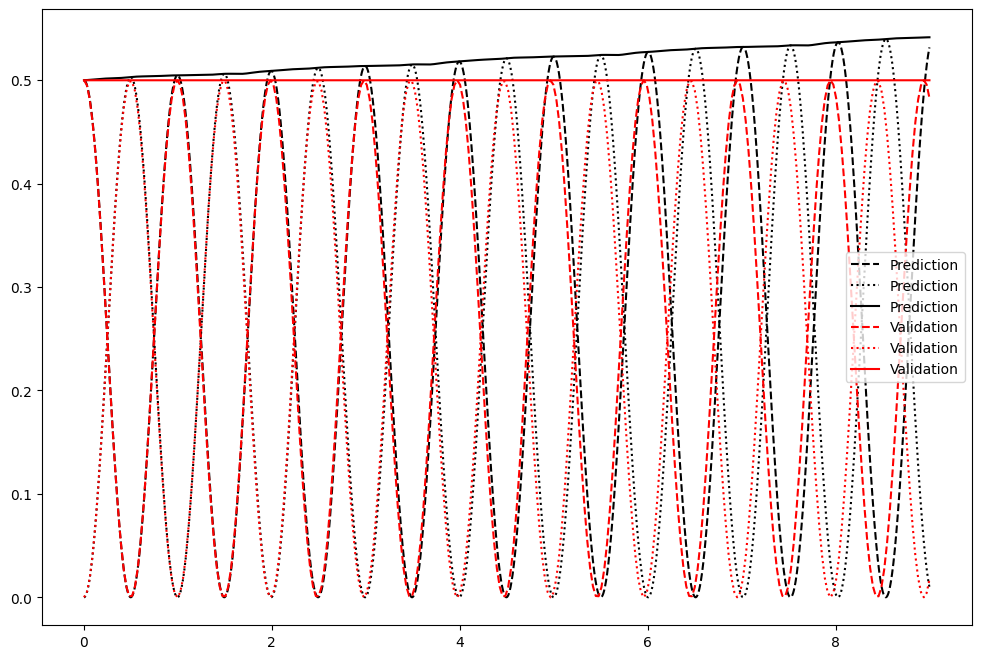

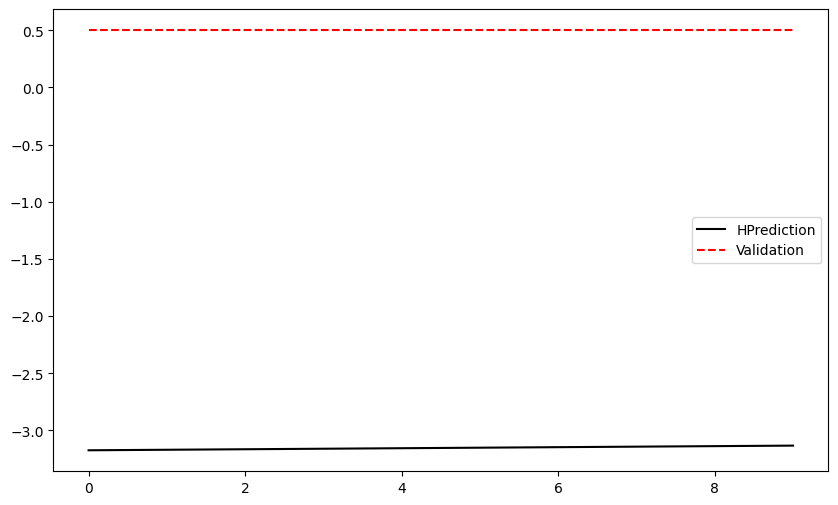

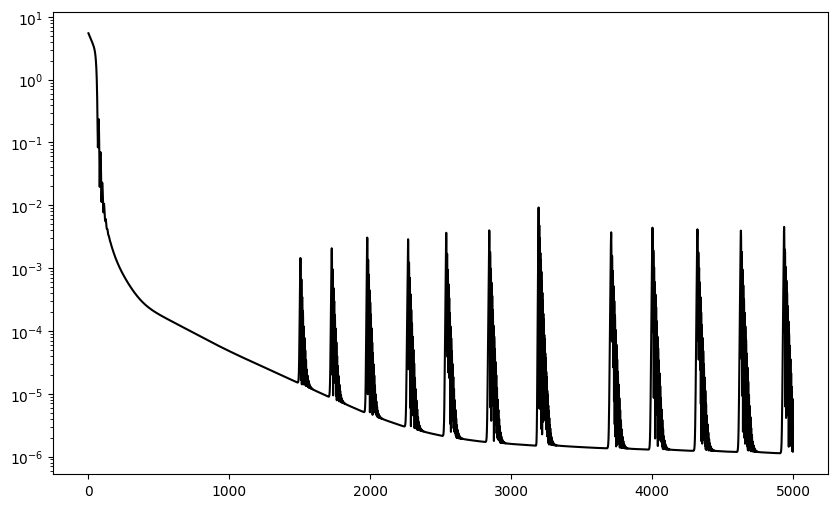

In [ ]:
# Exercicio 13_1 Hamiltonian & Lagrangian Neural Networks

import torch
import numpy as np
from torch.autograd import grad
import matplotlib.pyplot as plt

torch.manual_seed(2)
# é o comando para semear manualmente a semente, dessa forma o valor gerado se permanecerá o mesmo.

# User settings

# sampling parameters
dx0dt = 1
k = 10
m = 1

tmaxTraining = 1.5
numberOfTrainingSamples = 50
tmaxValidation = 9
numberOfValidationSamples = 300

# neural network architecture
neurons = 50
layers = 2

# hyperparameters
lr = 1e-3
epochs = 5000

# Utilities

# neural network
class FNN(torch.nn.Module):
# Comando para criar a rede neural
    def __init__(self, inputSize, outputSize, neurons, layers):
        super().__init__()

        self.layers = layers

        self.linear1 = torch.nn.Linear(inputSize, neurons)
# Ocorrerá uma transformação linear, utilizando o inputSize e Neurons
# É utilizado .linear1, .linear2 e .linear3 para ajudar o tratamento dos dados quando chegar no forward.
        self.linear2 = torch.nn.ModuleList()
# torch.nn.ModuleList() é uma lista especial para armazenar as camadas (Módulos) da rede neural.
        for i in range(self.layers):
            self.linear2.append(torch.nn.Linear(neurons, neurons))
#.append é uma forma de anexar em self.linear2 a informação de criação de uma camada fully connected com a mesma quantidade de neurônios na entrada e na saída
        self.linear3 = torch.nn.Linear(neurons, outputSize)
# Nessa linha, ocorre a transformação linear, onde como parametro de entrada são os neurons e gera o outputSize.
        self.activation = torch.nn.Tanh()
# Definição da função de ativação

    def forward(self, x):
# def forward é a definição de como os dados serão tratados
        y = self.activation(self.linear1(x))
# Inicio do loop
        for i in range(self.layers):
# range(self.layers) mostra qual será o limite de i (Lembrando que i possuira de 0 até self.linear -1)
            y = self.activation(self.linear2[i](y))
# Significa aplicar na camada inésima de linear2 os valores de y.
        y = self.linear3(y)
        return y

# derivative function

def getDerivative(y, x, n):
    """Compute the nth order derivative of y = f(x) with respect to x."""
# help(getDerivative) irá retornar o que está escrito entre as 3 aspas (É uma explicação do que essa função fará)
    if n == 0:
        return y
    else:

        dy_dx = grad(y, x, torch.ones_like(y), create_graph=True, retain_graph=True)[0]
# torch.ones_like(y) cria um tensor de mesmo tamanho de y.
# create_graph = true é o comando para permitir o grafo computacional para que a equação possa ser derivada novamente no futuro
# retain_graph = true é o comando que permite guardar o grafo computacional, importante quando é necessário derivar várias vezes.
        return getDerivative(dy_dx, x, n - 1)
# o input é uma derivada em relação a x, o n-1 é uma forma de mostrar que é um grau inferior.

# Data generation

#analytical solution

omega = np.sqrt(k / m)

A = dx0dt / omega
# A seria a amplitude
# Provavelmente dx0dt seria a velocidade máxima
# omega é a frequência ângular em rad/s

phi = 0
x = lambda t: A * np.sin(omega * t + phi)
# lambda t é uma forma de falar que recebe o tempo e retorna posição (neste caso).
# função posição, variando no tempo
dxdt = lambda t: omega * A * np.cos(omega * t + phi)
# lambda t é uma forma de falar que recebe o tempo e retorna velocidade ângular (neste caso).
ddxdtt = lambda t: - omega ** 2 * A * np.sin(omega * t + phi)
# lambda t é uma forma de falar que recebe o tempo e retorna aceleração ângular (neste caso).

# Training data
tTraining = np.linspace(0, tmaxTraining, numberOfTrainingSamples)
# Está criando vários pontos igualmente distribuidos de 0 até o tmaxtraining.
# TODO add noise
trainingData = torch.vstack((torch.from_numpy(x(tTraining)),
# torch.vstack é o comando para empilhar tensores verticalmente, onde cada tensor se torna uma nova linha.
# torch.from_numpy(x(tTraining)) ele joga os pontos criados em X, depois transforma esse numpy em um tensor.
                             m * torch.from_numpy(dxdt(tTraining)),
                             m * torch.from_numpy(ddxdtt(tTraining)))).to(torch.float32).T
# depois converte tudo para torch.float32 que é utilizado em redes neurais.
# .T faz a transposta da matriz.

# validation data
tValidation = np.linspace(0, tmaxValidation, numberOfValidationSamples)
validationData = torch.vstack((torch.from_numpy(x(tValidation)),
                               m * torch.from_numpy(dxdt(tValidation)),
                               m * torch.from_numpy(ddxdtt(tValidation)))).to(torch.float32).T

# model input

modelInputTraining = trainingData[:, :2]
# [:, :2] Significa que serão todas a linhas (por conta do "":"") e , :2 significa que serão as 2 primeiras colunas, no caso 0, 1 . Em outras palavras não irá pegar a informação da aceleração (Que seria a segunda derivada)
modelInputTraining.requires_grad = True
# Comando pedindo para otimizar os valores.
modelInputValidation = validationData[:, :2]
modelInputValidation.requires_grad = True

# Hamiltonian model training

# pre-processing

model = FNN(2, 1, neurons, layers)
# entre parenteses: o 2 significa que é um vetor de 2 parametros, 1 saida, qtd de neuronios, qtd de camadas.
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
costHistory = np.zeros(epochs)
# É uma forma de criar um vetor unidimensional do tamanho de epochs, sendo inicializado com zeros.

# training loop
for epoch in range(epochs):
    optimizer.zero_grad()

    HPred = model(modelInputTraining)

    dHPreddx = getDerivative(HPred, modelInputTraining, 1)
# esse 1 é uma forma de falar que é a derivada de primeira ordem
    cost = torch.mean((dHPreddx[:, 0] + trainingData[:, 2]) ** 2 + (dHPreddx[:, 1] - trainingData[:, 1] / m) ** 2)
# Ele pega todas as linhas do HPPreddx e sua primeira coluna.
    costHistory[epoch] = cost.detach()
# .detach() não traz os calculos relacionados ao gradiente.
    cost.backward()

    optimizer.step()

    if epoch % 50 == 0:
# A cada 50 épocas é rodado as linhas abaixo:
        print("Epoch: {}/{}\t\tCost function: {:.3E}".format(epoch, epochs, cost.detach()))
# .3 são 3 casas decimais e E é o input para exponencial.

# Post-processing

numberOfTimeSteps = 10000  # for the forward Euler scheme

# Forward Euler scheme

tPrediction = np.linspace(0, tmaxValidation, numberOfTimeSteps + 1)
# Acrescenta mais um ponto em relação a numberOfTimeSteps.
dt = tmaxValidation / numberOfTimeSteps
xPrediction = torch.zeros((2, numberOfTimeSteps + 1), requires_grad=False)
# Requires_grad = False é para não atualizar os valores durante o backpropagation!
xPrediction[:, 0] = validationData[0, :2] # initial conditions
# É uma forma de organizar os dados, onde xprediction recebera em todas suas linhas na sua primeira coluna os valores de validationData [ Onde pegara da primeira linha até as suas 2 primeiras colunas ]

HPredictions = np.zeros(numberOfTimeSteps)
HLabel = 0.5 * m * validationData[:, 1] ** 2 + 0.5 * k * validationData[:, 0] ** 2

for i in range(numberOfTimeSteps):
# Inicio do looping até a qtd de number ofTimesSteps
    currentx = xPrediction[:, i].unsqueeze(0).detach()
# .unsqueeze adiciona uma dimensão ao xprediction.
    currentx.requires_grad = True
# É o comando que solicita otimização dos valores.
    HPred = model(currentx)
    HPredictions[i] = HPred[0].detach()
    dHPreddx = getDerivative(HPred, currentx, 1)
    xPrediction[:, i + 1] = (xPrediction[:, i] + dt * torch.tensor([dHPreddx[0, 1], -dHPreddx[0, 0]])).detach()
# É uma forma de calcular a previsão, partindo do termo anterior somando sua derivada.

# transient response
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(tPrediction, xPrediction[0, :], 'k', label="Prediction")
ax.plot(tValidation, validationData[:, 0], 'r--', label="Validation")
ax.legend(loc='best')
plt.show()

# position-momentum space

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(xPrediction[0, :], xPrediction[1, :], 'k', label="Prediction")
ax.plot(validationData[:, 0], validationData[:, 1], 'r--', label="Validation")
ax.legend(loc='best')
plt.show()

# energy evolution

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(tPrediction, 0.5 / m * xPrediction[1, :] ** 2, 'k--', label="Prediction")
ax.plot(tPrediction, 0.5 * k * xPrediction[0, :] ** 2, 'k:' , label="Prediction")
ax.plot(tPrediction, 0.5 / m * xPrediction[1, :] ** 2 + 0.5 * k * xPrediction[0, :] ** 2, 'k', label="Prediction")

ax.plot(tValidation, 0.5 / m * validationData[:, 1] ** 2, 'r--', label="Validation")
ax.plot(tValidation, 0.5 * k * validationData[:, 0] ** 2, 'r:', label="Validation")
ax.plot(tValidation, 0.5 / m * validationData[:, 1] ** 2 + 0.5 * k * validationData[:, 0] ** 2, 'r', label="Validation")
ax.legend(loc='best')
plt.show()

# Hamiltonian prediction
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(tPrediction[:-1], HPredictions, 'k', label="HPrediction")
ax.plot(tValidation, HLabel, 'r--', label="Validation")
ax.legend(loc='best')
plt.show()

# learning history

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(costHistory, 'k')
ax.set_yscale('log')
plt.show()



Epoch: 0/5000		Cost function: 1.742E+01
Epoch: 50/5000		Cost function: 4.198E+00
Epoch: 100/5000		Cost function: 2.596E+00
Epoch: 150/5000		Cost function: 4.793E-02
Epoch: 200/5000		Cost function: 1.065E-02
Epoch: 250/5000		Cost function: 8.305E-03
Epoch: 300/5000		Cost function: 6.555E-03
Epoch: 350/5000		Cost function: 5.122E-03
Epoch: 400/5000		Cost function: 3.974E-03
Epoch: 450/5000		Cost function: 3.085E-03
Epoch: 500/5000		Cost function: 2.421E-03
Epoch: 550/5000		Cost function: 1.945E-03
Epoch: 600/5000		Cost function: 1.611E-03
Epoch: 650/5000		Cost function: 1.378E-03
Epoch: 700/5000		Cost function: 1.210E-03
Epoch: 750/5000		Cost function: 1.082E-03
Epoch: 800/5000		Cost function: 9.804E-04
Epoch: 850/5000		Cost function: 8.944E-04
Epoch: 900/5000		Cost function: 8.192E-04
Epoch: 950/5000		Cost function: 7.516E-04
Epoch: 1000/5000		Cost function: 6.901E-04
Epoch: 1050/5000		Cost function: 6.336E-04
Epoch: 1100/5000		Cost function: 5.814E-04
Epoch: 1150/5000		Cost function: 5

/tmp/ipython-input-1524108728.py:148: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  xPrediction[:, i + 1] = (xPrediction[:, i] + dt * torch.tensor([currentx[0, 1], ddxttPred[0]])).detach() # Aqui é diferente


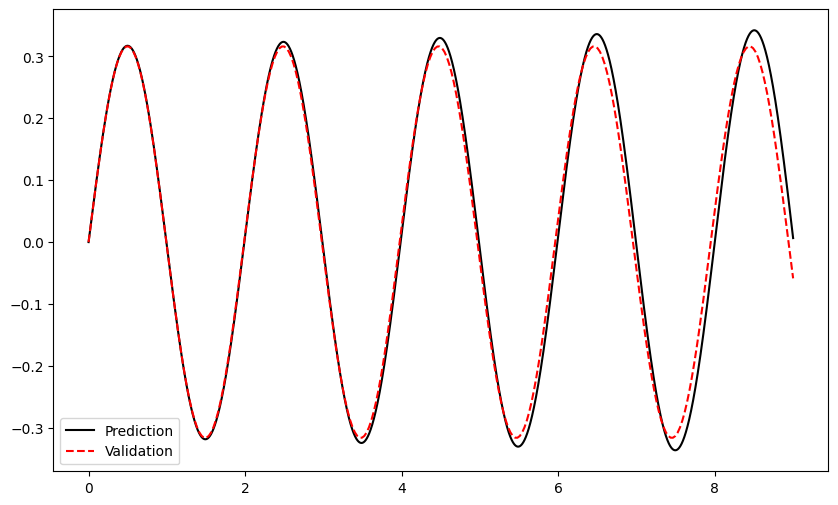

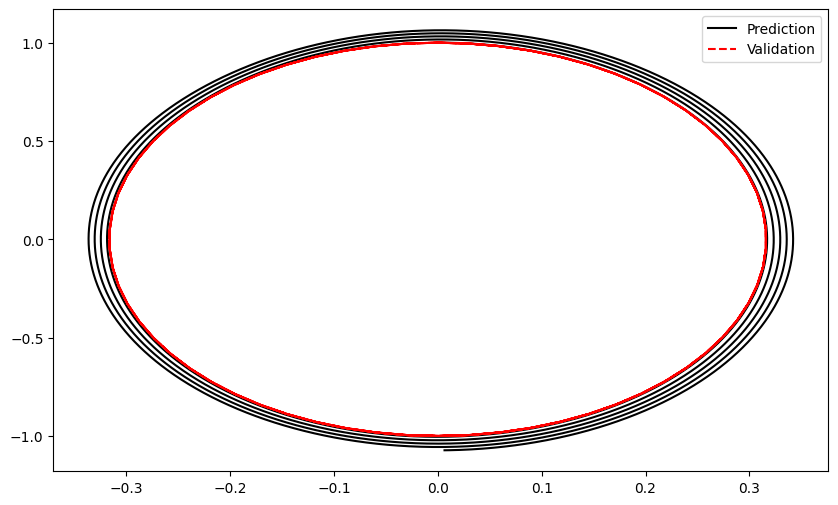

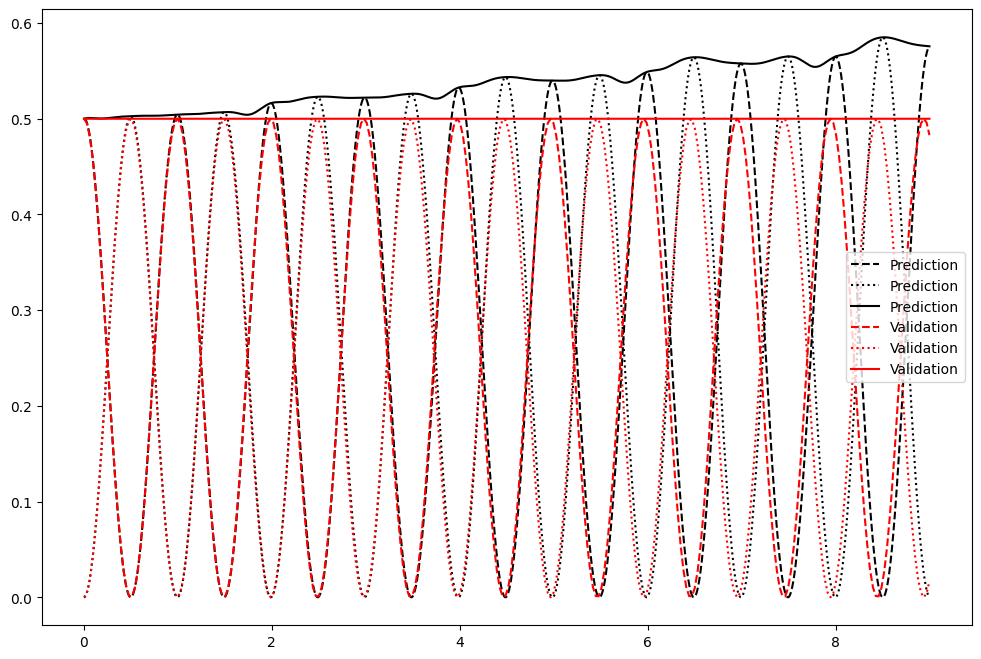

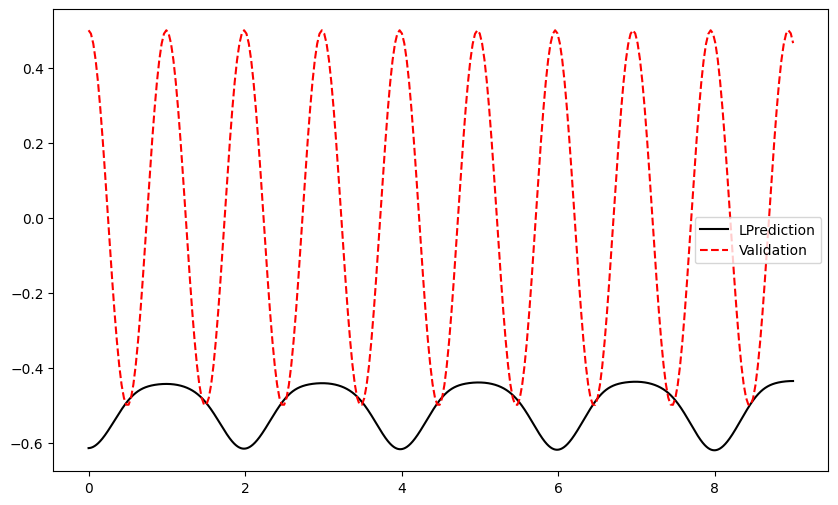

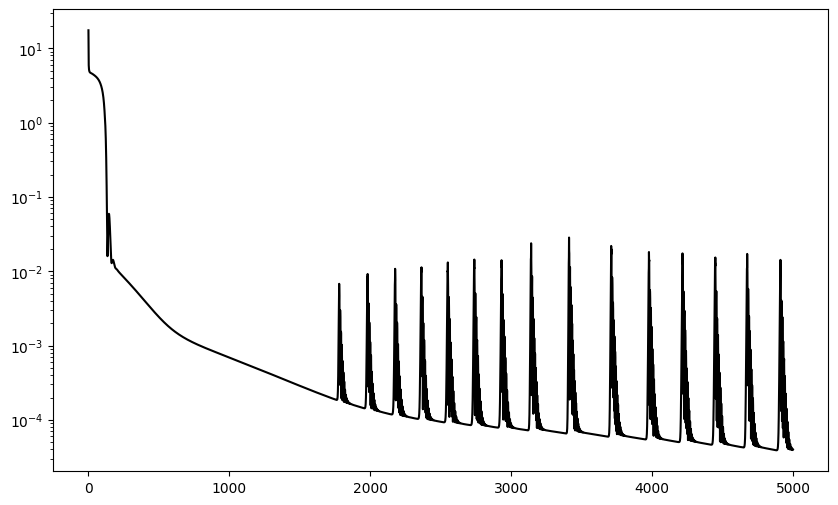

In [2]:
# Ex 13_2 Hamiltonian & Lagrangian Neural Networks

import torch
import numpy as np
from torch.autograd import grad
import matplotlib.pyplot as plt

torch.manual_seed(1)
# Nota-se que o valor entre parênteses já é diferente em relação ao 13_1

# User settings

# sampling parameters (Igual ao anterior)
dx0dt = 1
k = 10
m = 1

tmaxTraining = 1.5
numberOfTrainingSamples = 50
tmaxValidation = 9
numberOfValidationSamples = 300

# neural network architecture (Igual ao anterior)
neurons = 50
layers = 2

# hyperparameters (Igual ao anterior)
lr = 1e-3
epochs = 5000

# Utilities

# neural network
class FNN(torch.nn.Module): # Igual ao anterior
    def __init__(self, inputSize, outputSize, neurons, layers):
        super().__init__()

        self.layers = layers

        self.linear1 = torch.nn.Linear(inputSize, neurons)
        self.linear2 = torch.nn.ModuleList()
        for i in range(self.layers):
            self.linear2.append(torch.nn.Linear(neurons, neurons))
        self.linear3 = torch.nn.Linear(neurons, outputSize)
        self.activation = torch.nn.Tanh()

    def forward(self, x):
        y = self.activation(self.linear1(x))
        for i in range(self.layers):
            y = self.activation(self.linear2[i](y))
        y = self.linear3(y)
        return y

# derivative function (Igual ao anterior)

def getDerivative(y, x, n):
    """Compute the nth order derivative of y = f(x) with respect to x."""

    if n == 0:
        return y
    else:
        dy_dx = grad(y, x, torch.ones_like(y), create_graph=True, retain_graph=True)[0]
        return getDerivative(dy_dx, x, n - 1)

# Data generation

# analytical solution (Igual ao anterior)
omega = np.sqrt(k / m)

A = dx0dt / omega
phi = 0
x = lambda t: A * np.sin(omega * t + phi)
dxdt = lambda t: omega * A * np.cos(omega * t + phi)
ddxdtt = lambda t: - omega ** 2 * A * np.sin(omega * t + phi)

# training data (Igual ao anterior)
tTraining = np.linspace(0, tmaxTraining, numberOfTrainingSamples)
# TODO add noise
trainingData = torch.vstack((torch.from_numpy(x(tTraining)),
                             torch.from_numpy(dxdt(tTraining)),
                             torch.from_numpy(ddxdtt(tTraining)))).to(torch.float32).T

# validation data (Igual ao anterior)
tValidation = np.linspace(0, tmaxValidation, numberOfValidationSamples)
validationData = torch.vstack((torch.from_numpy(x(tValidation)),
                               torch.from_numpy(dxdt(tValidation)),
                               torch.from_numpy(ddxdtt(tValidation)))).to(torch.float32).T

# Model input (Igual ao anterior)

modelInputTraining = trainingData[:, :2]
modelInputTraining.requires_grad = True

modelInputValidation = validationData[:, :2]
modelInputValidation.requires_grad = True

# Hamiltonian model training

# pre-processing (Igual ao anterior)

model = FNN(2, 1, neurons, layers)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
costHistory = np.zeros(epochs)

# training loop ( Aqui é diferente)

for epoch in range(epochs):
    optimizer.zero_grad()

    LPred = model(modelInputTraining) # Aqui é diferente.

    dLPreddx = getDerivative(LPred, modelInputTraining, 1)
    Hessian = getDerivative(dLPreddx[:, 0], modelInputTraining, 1)[:, 1] # Aqui é diferente
    ddxttPred = (1. / dLPreddx[:, 1]) * (dLPreddx[:, 0] - Hessian * modelInputTraining[:, 1]) # Aqui é diferente
    cost = torch.mean((trainingData[:, 2] - ddxttPred) ** 2) # Aqui é diferente
    costHistory[epoch] = cost.detach()

    cost.backward()

    optimizer.step()

    if epoch % 50 == 0:
        print("Epoch: {}/{}\t\tCost function: {:.3E}".format(epoch, epochs, cost.detach()))

# Post-processing

numberOfTimeSteps = 10000 # Aqui é igual

# forward Euler scheme (Aqui é diferente)
tPrediction = np.linspace(0, tmaxValidation, numberOfTimeSteps + 1) # Aqui é igual
dt = tmaxValidation / numberOfTimeSteps # Aqui é igual
xPrediction = torch.zeros((2, numberOfTimeSteps + 1), requires_grad=False) # Aqui é igual
xPrediction[:, 0] = validationData[0, :2] # Aqui é igual

LPredictions = np.zeros(numberOfTimeSteps) # Aqui é diferente onde salvamos
LLabel = 0.5 * m * validationData[:, 1] ** 2 - 0.5 * k * validationData[:, 0] ** 2 # Aqui é diferente onde salvamos

for i in range(numberOfTimeSteps):
    currentx = xPrediction[:, i].unsqueeze(0).detach()
    currentx.requires_grad = True
    LPred = model(currentx) # Aqui é diferente
    LPredictions[i] = LPred[0].detach() # Aqui é diferente

    dLPreddx = getDerivative(LPred, currentx, 1) # Aqui é diferente
    Hessian = getDerivative(dLPreddx[:, 0], currentx, 1)[:, 1] # Aqui é diferente
    ddxttPred = (1. / dLPreddx[:, 1]) * (dLPreddx[:, 0] - Hessian * currentx[:, 1]) # Aqui é diferente

    xPrediction[:, i + 1] = (xPrediction[:, i] + dt * torch.tensor([currentx[0, 1], ddxttPred[0]])).detach() # Aqui é diferente

# transient response

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(tPrediction, xPrediction[0, :], 'k', label="Prediction")
ax.plot(tValidation, validationData[:, 0], 'r--', label="Validation")
ax.legend(loc='best')
plt.show()

# position-momentum space
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(xPrediction[0, :], xPrediction[1, :], 'k', label="Prediction")
ax.plot(validationData[:, 0], validationData[:, 1], 'r--', label="Validation")
ax.legend(loc='best')
plt.show()

# energy evolution
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(tPrediction, 0.5 / m * xPrediction[1, :] ** 2, 'k--', label="Prediction")
ax.plot(tPrediction, 0.5 * k * xPrediction[0, :] ** 2, 'k:', label="Prediction")
ax.plot(tPrediction, 0.5 / m * xPrediction[1, :] ** 2 + 0.5 * k * xPrediction[0, :] ** 2, 'k', label="Prediction")

ax.plot(tValidation, 0.5 / m * validationData[:, 1] ** 2, 'r--', label="Validation")
ax.plot(tValidation, 0.5 * k * validationData[:, 0] ** 2, 'r:', label="Validation")
ax.plot(tValidation, 0.5 / m * validationData[:, 1] ** 2 + 0.5 * k * validationData[:, 0] ** 2, 'r', label="Validation")
ax.legend(loc="best")
plt.show()

# Lagrangian prediction
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(tPrediction[:-1], LPredictions, 'k', label="LPrediction")
ax.plot(tValidation, LLabel, 'r--', label="Validation")
ax.legend(loc='best')
plt.show()

# learning history
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(costHistory, 'k')
ax.set_yscale('log')
plt.show()

Epoch: 0/5000		Cost function: 2.999E+00
Epoch: 50/5000		Cost function: 7.894E-01
Epoch: 100/5000		Cost function: 1.921E-03
Epoch: 150/5000		Cost function: 4.565E-04
Epoch: 200/5000		Cost function: 3.131E-04
Epoch: 250/5000		Cost function: 2.380E-04
Epoch: 300/5000		Cost function: 1.925E-04
Epoch: 350/5000		Cost function: 1.616E-04
Epoch: 400/5000		Cost function: 1.381E-04
Epoch: 450/5000		Cost function: 1.189E-04
Epoch: 500/5000		Cost function: 1.028E-04
Epoch: 550/5000		Cost function: 8.898E-05
Epoch: 600/5000		Cost function: 7.704E-05
Epoch: 650/5000		Cost function: 6.668E-05
Epoch: 700/5000		Cost function: 5.765E-05
Epoch: 750/5000		Cost function: 4.979E-05
Epoch: 800/5000		Cost function: 4.296E-05
Epoch: 850/5000		Cost function: 3.705E-05
Epoch: 900/5000		Cost function: 3.194E-05
Epoch: 950/5000		Cost function: 2.755E-05
Epoch: 1000/5000		Cost function: 2.380E-05
Epoch: 1050/5000		Cost function: 2.059E-05
Epoch: 1100/5000		Cost function: 1.787E-05
Epoch: 1150/5000		Cost function: 1

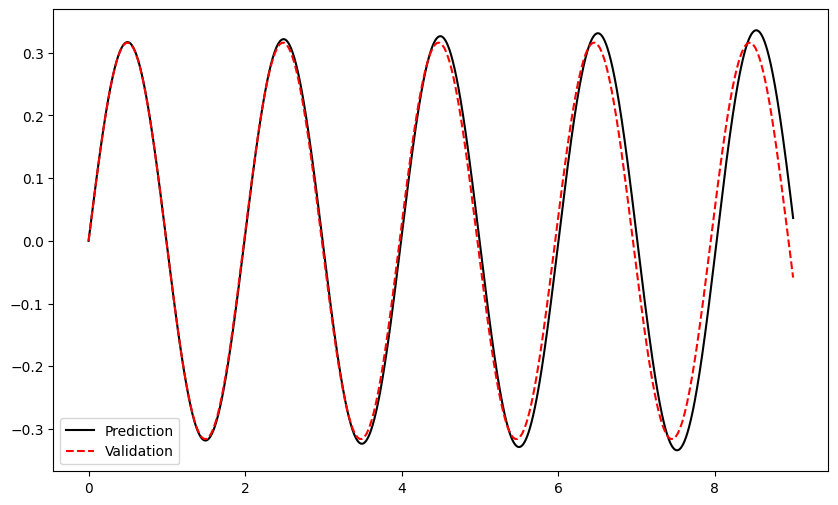

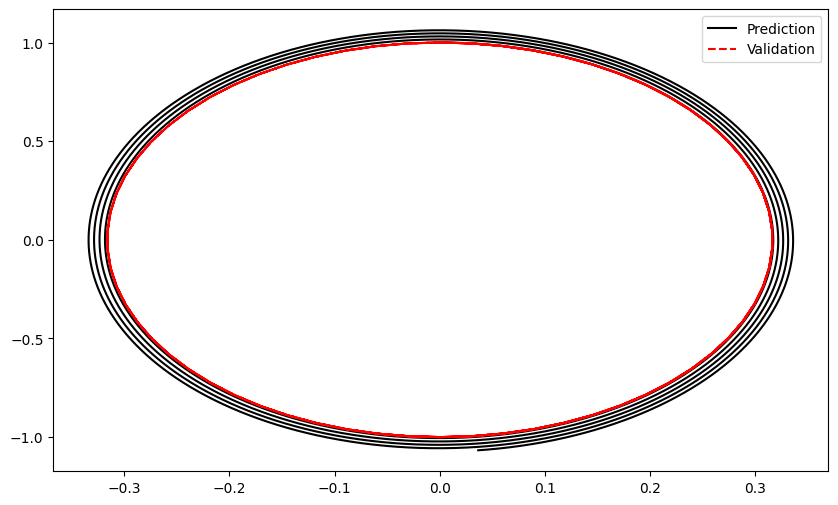

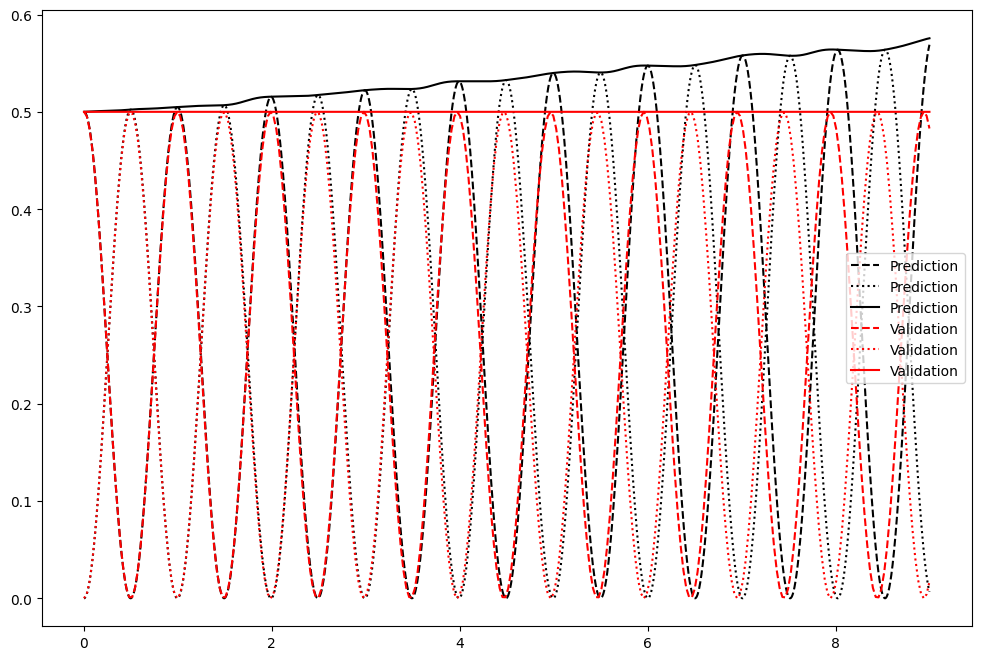

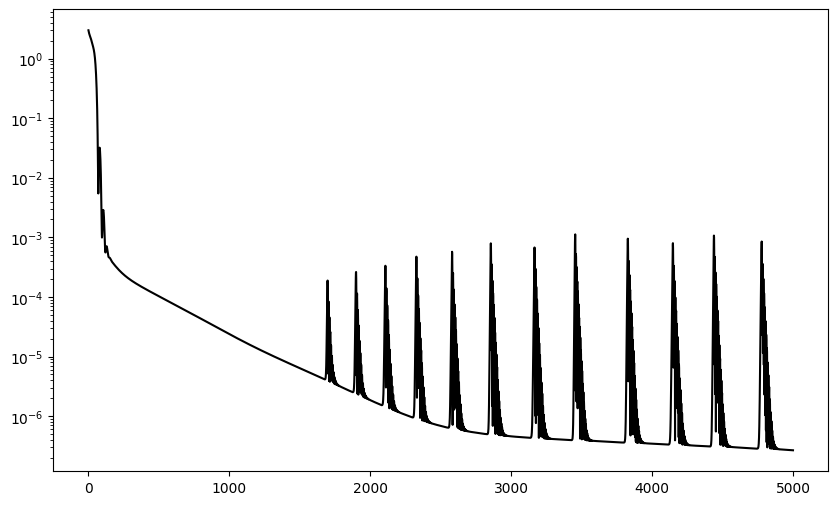

In [6]:
# Exercicio 13_3 Hamiltonian & Lagrangian Neural Networks
# As linhas sem comentários são linhas que estão presentes no 13_1.

import torch
import numpy as np
from torch.autograd import grad
import matplotlib.pyplot as plt

torch.manual_seed(2)

# User settings

# sampling parameters
dx0dt = 1
k = 10
m = 1

tmaxTraining = 1.5
numberOfTrainingSamples = 50
tmaxValidation = 9
numberOfValidationSamples = 300

# neural network architecture
neurons = 50
layers = 2

# hyperparameters
lr = 1e-3
epochs = 5000

# Utilities

# neural network

class FNN(torch.nn.Module):
    def __init__(self, inputSize, outputSize, neurons, layers):
        super().__init__()

        self.layers = layers

        self.linear1 = torch.nn.Linear(inputSize, neurons)
        self.linear2 = torch.nn.ModuleList()
        for i in range(self.layers):
            self.linear2.append(torch.nn.Linear(neurons, neurons))
        self.linear3 = torch.nn.Linear(neurons, outputSize)
        self.activation = torch.nn.Tanh()

    def forward(self, x):
        y = self.activation(self.linear1(x))
        for i in range(self.layers):
            y = self.activation(self.linear2[i](y))
        y = self.linear3(y)
        return y
# derivative function

def getDerivative(y, x, n):
    """Compute the nth order derivative of y = f(x) with respect to x."""

    if n == 0:
        return y
    else:
        dy_dx = grad(y, x, torch.ones_like(y), create_graph=True, retain_graph=True)[0]
        return getDerivative(dy_dx, x, n - 1)

# Data generation

# analytical solution
omega = np.sqrt(k / m)

A = dx0dt / omega
phi = 0
x = lambda t: A * np.sin(omega * t + phi)
dxdt = lambda t: omega * A * np.cos(omega * t + phi)
ddxdtt = lambda t: - omega ** 2 * A * np.sin(omega * t + phi)

# training data

tTraining = np.linspace(0, tmaxTraining, numberOfTrainingSamples)
trainingData = torch.vstack((torch.from_numpy(x(tTraining)),
                             m * torch.from_numpy(dxdt(tTraining)),
                             m * torch.from_numpy(ddxdtt(tTraining)))).to(torch.float32).T
# validation data
tValidation = np.linspace(0, tmaxValidation, numberOfValidationSamples)
validationData = torch.vstack((torch.from_numpy(x(tValidation)),
                               m * torch.from_numpy(dxdt(tValidation)),
                               m * torch.from_numpy(ddxdtt(tValidation)))).to(torch.float32).T

# Model input
modelInputTraining = trainingData[:, :2]
modelInputTraining.requires_grad = True

modelInputValidation = validationData[:, :2]
modelInputValidation.requires_grad = True

# Supervised training (Aqui é novo)

# pre-processing

model = FNN(2, 2, neurons, layers)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
costHistory = np.zeros(epochs)

# training loop

for epoch in range(epochs):
    optimizer.zero_grad()

    xPred = model(modelInputTraining)

    cost = torch.mean((xPred - trainingData[:, 1:]) ** 2) # Aqui é diferente.
    costHistory[epoch] = cost.detach()

    cost.backward()

    optimizer.step()

    if epoch % 50 == 0:
        print("Epoch: {}/{}\t\tCost function: {:.3E}".format(epoch, epochs, cost.detach()))

# Post-processing

numberOfTimeSteps = 10000  # for the forward Euler scheme

# forward Euler scheme

tPrediction = np.linspace(0, tmaxValidation, numberOfTimeSteps + 1)
dt = tmaxValidation / numberOfTimeSteps
xPrediction = torch.zeros((2, numberOfTimeSteps + 1), requires_grad=False)

xPrediction[:, 0] = validationData[0, :2]

for i in range(numberOfTimeSteps):
    xPrediction[:, i + 1] = (xPrediction[:, i] + dt * model(xPrediction[:, i])).detach()

# transient response
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(tPrediction, xPrediction[0, :], 'k', label="Prediction")
ax.plot(tValidation, validationData[:, 0], 'r--', label="Validation")
ax.legend(loc='best')
plt.show()

# position-momentum space
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(xPrediction[0, :], xPrediction[1, :], 'k', label="Prediction")
ax.plot(validationData[:, 0], validationData[:, 1], 'r--', label="Validation")
ax.legend(loc='best')
plt.show()

# energy evolution
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(tPrediction, 0.5 / m * xPrediction[1, :] ** 2, 'k--', label="Prediction")
ax.plot(tPrediction, 0.5 * k * xPrediction[0, :] ** 2, 'k:', label="Prediction")
ax.plot(tPrediction, 0.5 / m * xPrediction[1, :] ** 2 + 0.5 * k * xPrediction[0, :] ** 2, 'k', label="Prediction")

ax.plot(tValidation, 0.5 / m * validationData[:, 1] ** 2, 'r--', label="Validation")
ax.plot(tValidation, 0.5 * k * validationData[:, 0] ** 2, 'r:', label="Validation")
ax.plot(tValidation, 0.5 / m * validationData[:, 1] ** 2 + 0.5 * k * validationData[:, 0] ** 2, 'r', label="Validation")
ax.legend(loc='best')
plt.show()

# learning history
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(costHistory, 'k')
ax.set_yscale('log')
plt.show()